In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import os
from IPython.display import clear_output
import warnings

# Ручная разметка

## Функция определения сегментов
    csv_file_path,
    smoothing_window=5,   # окно сглаживания
    outlier_factor=5.0,   # фактор для определения выбросов (через MAD)
    noise_tolerance=0.2,  # допустимая "зона шума" при смене тренда
    min_points=20,        # минимальное количество точек в сегменте
    maxval_proc=70,       # процент от максимального давления, который должен быть в сегменте
    cnt_log_cycles=2,     # параметр, определяющий разрывы во времени в лог-шкале
    plot=1,               # флаг построения графика
    show_autor_patterns=0,# флаг отображения "авторской" разметки из столбца "class"
    scatter_plot=0,       # 0 -> все графики через scatter, 1 -> все графики через plot (авторская разметка всё равно scatter)
    graph_mad=0           # 0 -> рисуем df_clean["pressure"], 1 -> рисуем df_clean["pressure_smooth"]

## Алгоритм разметки

In [66]:
def detect_monotonic_segments_ignore_outliers(
    csv_file_path,
    smoothing_window=27,
    outlier_factor=0,
    noise_tolerance=0,
    min_points=20,
    maxval_proc=80,
    cnt_log_cycles=2.5,
    show_autor_patterns=1,
    scatter_plot=1,
    graph_mad=0,
    plot=1
):
    """
    Поиск монотонных сегментов (возрастание/убывание) с исключением выбросов.
    Возвращает словарь: {1: [(start_time, end_time), ...], -1: [...]}.
    """

    """
    graph_mad : int
        0 -> При построении графика использовать исходный столбец 'pressure' (но без выбросов).
        1 -> При построении графика использовать сглаженный столбец 'pressure_smooth'.
    """

    #----------------------------------------------------------------
    # Шорткат-функции для отрисовки основного графика
    def plot_data_main(x, y, label=None, color=None):
        """Рисует основной трек (в зависимости от graph_mad)."""
        if scatter_plot == 0:
            plt.scatter(x, y, label=label, c=color)
        else:
            plt.plot(x, y, label=label, color=color, alpha=0.7)

    # Функция для отрисовки авторской разметки (всегда scatter)
    def plot_data_autor(x, y, label=None, color=None):
        plt.scatter(x, y, label=label, c=color)
    #----------------------------------------------------------------

    df = pd.read_csv(csv_file_path).sort_values(by="time").reset_index(drop=True)
    max_pressure = df["pressure"].max()
    threshold_pressure = (maxval_proc / 100.0) * max_pressure
    df["pressure_smooth"] = (
        df["pressure"]
        .rolling(window=smoothing_window, center=True, min_periods=1)
        .median()
    )
    mad = np.median(np.abs(df["pressure"] - df["pressure_smooth"]))
    threshold = outlier_factor * mad
    df["is_outlier"] = np.abs(df["pressure"] - df["pressure_smooth"]) > threshold
    df_clean = df[~df["is_outlier"]].reset_index(drop=True)
    if len(df_clean) < 2:
        return {1: [], -1: []}

    segments = {1: [], -1: []}
    current_trend = None
    current_start_idx = None
    last_valid_index = None
    n = len(df_clean)
    log_threshold = cnt_log_cycles * math.log(10)

    #----------------------------------------------------------------
    # Выбираем, какие значения будем рисовать на графике
    # (для поиска сегментов логика всё равно использует 'pressure_smooth',
    #  но визуализация может идти по 'pressure' или 'pressure_smooth')
    pressure_col_for_plot = "pressure_smooth" if graph_mad == 1 else "pressure"
    #----------------------------------------------------------------

    def close_segment(end_idx, trend):
        seg_length = end_idx - current_start_idx + 1
        if seg_length >= min_points:
            segment_data = df_clean.iloc[current_start_idx:end_idx + 1]
            if (segment_data["pressure"] >= threshold_pressure).any():
                start_time = segment_data.iloc[0]["time"]
                end_time = segment_data.iloc[-1]["time"]
                segments[trend].append((start_time, end_time))

    def get_sign_and_change(old_trend, diff, noise_tolerance):
        if diff > 0:
            raw_sign = 1
        elif diff < 0:
            raw_sign = -1
        else:
            raw_sign = 0
        changed = False
        if old_trend is None:
            return raw_sign, False
        if old_trend != 0 and raw_sign != 0:
            if (raw_sign != old_trend) and (abs(diff) > noise_tolerance):
                changed = True
        return raw_sign, changed

    for i in range(1, n):
        time_prev = df_clean.loc[i - 1, "time"]
        time_curr = df_clean.loc[i, "time"]
        if time_prev <= 0 or time_curr <= 0:
            log_diff = 0
        else:
            log_diff = math.log(time_curr) - math.log(time_prev)
        diff = df_clean.loc[i, "pressure_smooth"] - df_clean.loc[i - 1, "pressure_smooth"]
        new_sign, changed = get_sign_and_change(current_trend, diff, noise_tolerance)
        if current_trend is None:
            if new_sign != 0:
                current_trend = new_sign
                current_start_idx = i - 1
                last_valid_index = i - 1
            continue
        log_exceeded = (log_diff > log_threshold)
        if changed or log_exceeded:
            close_segment(last_valid_index, current_trend)
            if log_exceeded:
                current_trend = new_sign if new_sign != 0 else None
                current_start_idx = i
                last_valid_index = i
            else:
                if new_sign != 0:
                    current_trend = new_sign
                    current_start_idx = i - 1
                    last_valid_index = i - 1
                else:
                    current_trend = None
                    current_start_idx = None
                    last_valid_index = None
        else:
            last_valid_index = i
            if new_sign != 0:
                current_trend = new_sign

    if current_trend is not None and last_valid_index is not None and current_start_idx is not None:
        close_segment(last_valid_index, current_trend)
        
    #----------------------------------------------------------------
    # Рисуем, если нужно
    if plot == 1:
        plt.figure(figsize=(12, 6))

        # Рисуем выбранную колонку (raw или smooth)
        plot_data_main(
            x=df_clean["time"],
            y=df_clean[pressure_col_for_plot],
            label=("Сглаженное давление (clean)" if graph_mad == 1 else "Исходное давление (clean)"),
            color="gray"
        )

        # Авторская разметка, если включена
        if show_autor_patterns == 1 and "class" in df.columns:
            df_inc = df[df["class"] == 1]  # рост (авторская разметка)
            if not df_inc.empty:
                plot_data_autor(
                    x=df_inc["time"],
                    y=df_inc["pressure"],
                    label="возрастание (авт. разм.)",
                    color="yellow"
                )
            df_dec = df[df["class"] == 2]  # убывание (авторская разметка)
            if not df_dec.empty:
                plot_data_autor(
                    x=df_dec["time"],
                    y=df_dec["pressure"],
                    label="убывание (авт. разм.)",
                    color="blue"
                )

        # Отмечаем найденные монотонные сегменты
        for trend, seg_list in segments.items():
            color = "green" if trend == 1 else "red"
            label = "Возрастание" if trend == 1 else "Убывание"
            for (start_time, end_time) in seg_list:
                mask = (df_clean["time"] >= start_time) & (df_clean["time"] <= end_time)
                plot_data_main(
                    x=df_clean.loc[mask, "time"],
                    y=df_clean.loc[mask, pressure_col_for_plot],
                    label=label,
                    color=color
                )

        plt.xlabel("Время")
        plt.ylabel("Давление")
        plt.title(
            f"window: {smoothing_window}, outlier_factor: {outlier_factor}, noise_tolerance: {noise_tolerance},\n"
            f"min_points: {min_points}, maxval_proc: {maxval_proc}, cnt_log_cycles: {cnt_log_cycles}, graph_mad: {graph_mad}"
        )

        # Убираем дублирующиеся метки в легенде
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())
        plt.grid(True)
        plt.show()
        #----------------------------------------------------------------


    return segments


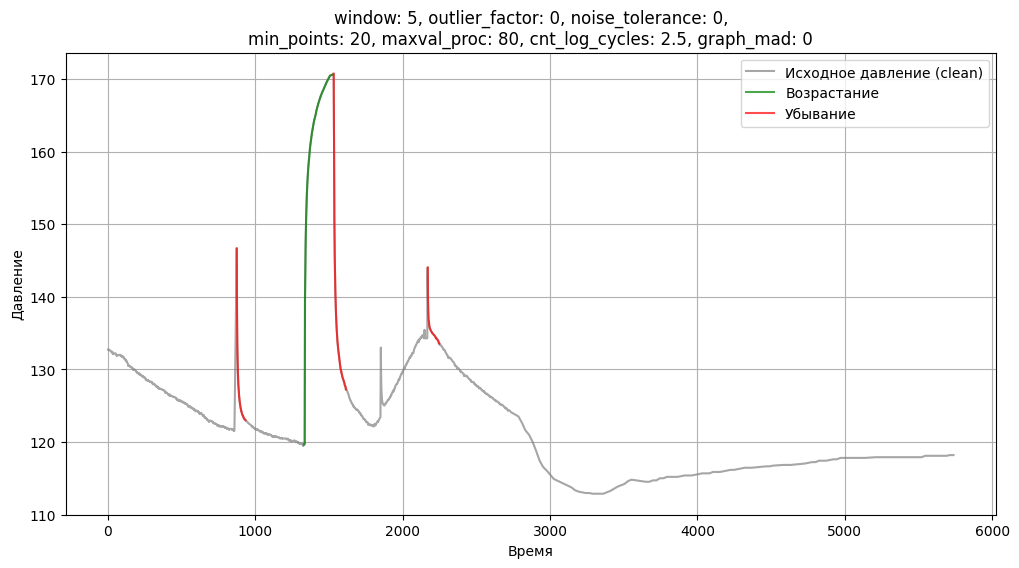

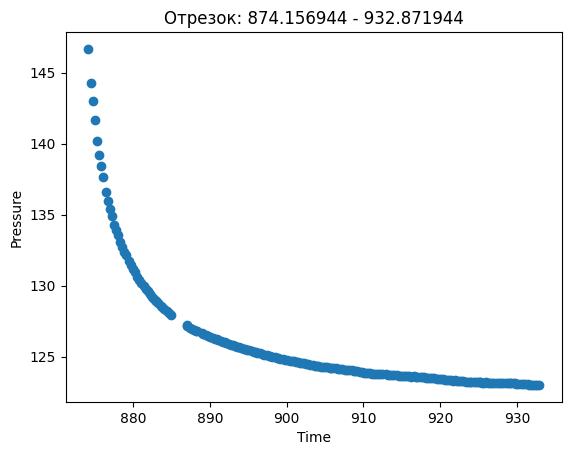

ValueError: invalid literal for int() with base 10: ''

In [67]:
'''
Метки
0 - нет паттерна
1 - recovery 
2 - drop 
3 - не уверен в пресказании

dfs - список с словарями - {'file_name' : df с разметкой}
'''

# Игнорирование всех предупреждений
warnings.filterwarnings('ignore')

dfs = []

folder_path = 'test_files'

for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    if os.path.isfile(file_path) and file_path.endswith('.csv'):  # Проверяем, что это CSV файл
        # Загрузка данных
        data = pd.read_csv(file_path)
        time = data['time']
        pressure = data['pressure']
        
        # Применение функции для поиска монотонных сегментов
        segments = detect_monotonic_segments_ignore_outliers(
            file_path
        )
        
        # Создаем DataFrame для текущего файла
        df = pd.DataFrame(columns=['time_start', 'time_stop', 'class'])
        for i in [-1, 1]:
            for segment in segments[i]:
                # Рисуем график для каждого сегмента
                segment_time = time[(time >= segment[0]) & (time <= segment[1])]
                segment_pressure = pressure[(time >= segment[0]) & (time <= segment[1])]
                
                plt.scatter(segment_time, segment_pressure)
                plt.xlabel('Time')
                plt.ylabel('Pressure')
                plt.title(f'Отрезок: {segment[0]} - {segment[1]}')
                # Находим максимальное и минимальное значение pressure в сегменте
                max_pressure = data['pressure'].max()
                min_pressure = data['pressure'].min()
                
                # Рассчитываем 80% от максимального значения pressure
                eighty_percent_max = 0.8 * max_pressure
                
                # Добавляем текст на график (максимальное, минимальное значение и 80% от максимума)
                plt.text(
                    segment_time.iloc[0], max_pressure, f'Max: {max_pressure:.2f}', color='green', fontsize=10
                )
                plt.text(
                    segment_time.iloc[0], min_pressure, f'Min: {min_pressure:.2f}', color='red', fontsize=10
                )
                plt.text(
                    segment_time.iloc[0], eighty_percent_max, f'80% of Max: {eighty_percent_max:.2f}', color='blue', fontsize=10
                )
                
                plt.show()
                
                # Запрос метки от пользователя
                class_label = input(f'Поставьте метку для отрезка {segment[0]} - {segment[1]} (0, 1 или 2): ')
                class_label = int(class_label)
                
                # Добавляем данные в DataFrame
                # Создаем временный DataFrame с новыми данными
                new_row = pd.DataFrame({'time_start': [segment[0]], 'time_stop': [segment[1]], 'class': [class_label]})
                
                # Добавляем строку в основной DataFrame с помощью pd.concat()
                df = pd.concat([df, new_row], ignore_index=True)

                clear_output(wait=True)
            
        # Добавляем DataFrame в список dfs с именем файла
        dfs.append({'filename': filename, 'df': df})

In [7]:
for file_data in dfs:
    print(f"DataFrame для файла {file_data['filename']}:")
    print(file_data['df'])

# Объединяем все DataFrame в один
combined_df = pd.concat([file_data["df"].assign(filename=file_data["filename"]) for file_data in dfs], ignore_index=True)

# Сохраняем в файл
combined_df.to_csv('razmetka.csv', index=False)

print("Файл razmetka.csv успешно сохранен!")

DataFrame для файла 5dbc4812-135e-4e6b-9a14-e2cde50489f5.csv:
     time_start     time_stop class
0   3659.144722   3835.795556     0
1  15619.800000  17010.819167     0
2  17010.819167  18071.354444     2
DataFrame для файла 7dc0adee-fbfb-46a0-803d-54275561d1eb.csv:
     time_start     time_stop class
0   4134.876389   5487.541389     2
1  12250.384722  12520.073333     2
2     17.545556   1505.274722     0
3   1505.274722   4134.876389     0
4  10789.803611  12250.384722     0
DataFrame для файла 4b144e52-3d8f-4c8b-82a0-a1e9725794a9.csv:
    time_start    time_stop class
0  1781.001944  2848.782222     1
1  2848.782222  3098.005278     0
DataFrame для файла 15ed4c6f-686e-4b60-97ea-ed55a1f00ce9.csv:
    time_start    time_stop class
0     0.274167   717.231389     2
1  3288.175556  3479.624167     1
2  3479.624167  3807.977500     2
DataFrame для файла 837241ab-62c5-437c-a78b-ebecb64b9905.csv:
     time_start     time_stop class
0   2078.502222   3225.446667     0
1   3228.337222   38

In [10]:
df = pd.read_csv('/Users/glebovmaksim/Desktop/VOST_0.6796/razmetka_files/razmetka.csv')

result_df = df.groupby('filename').apply(
    lambda g: pd.Series({
        'recovery': g.loc[g['class'] == 1, ['time_start', 'time_stop']].values.tolist(),
        'drop': g.loc[g['class'] == 2, ['time_start', 'time_stop']].values.tolist()
    })
).reset_index()

result_df = result_df.rename(columns={"filename": "file"})
result_df['file'] = result_df['file'].str.replace('.csv', '', regex=False)
result_df.to_csv('full_test_subm.csv',index=False)

In [11]:
result_df

,file,recovery,drop
0,088b59d5-d011-47ca-8738-f46683596220,"[[2358.675278, 3497.172778]]",[]
1,09bc865d-589e-4fcc-9b7e-4ac674a390dd,[],"[[2338.416667, 2545.494167]]"
2,13850102-9e0e-4e3a-842c-00b993d62045,[],"[[2552.179444, 3759.357222]]"
3,15ed4c6f-686e-4b60-97ea-ed55a1f00ce9,"[[3269.490833, 3479.624167]]","[[3479.624167, 3540.01]]"
4,164abd51-13d5-4a6f-9841-46d82937e377,"[[5674.736389, 5932.550278], [20450.846389, 20...","[[20557.0825, 20928.535833]]"
5,17859c48-3b19-48d6-a79b-793390e70803,[],"[[3.6, 1045.483333]]"
6,1896a0c8-8130-472e-ba6f-9dcfed363dce,"[[546.591667, 1974.948611]]","[[1974.948611, 2843.459444], [5006.943611, 528..."
7,1c0e8d10-ba4a-499f-8159-bde6dc70b1c8,[],"[[0.142778, 1104.3], [5088.064722, 5208.440278]]"
8,1c9db047-e335-46ac-8039-effd8589b25b,"[[2352.118889, 2382.312222]]","[[338.711111, 454.713333], [2382.312222, 2646...."
9,1cbce6e5-9f0b-419f-9527-7add4e255217,"[[3176.104722, 3633.758056]]","[[3633.758056, 3765.223333], [7496.344722, 784..."
